# Example with wells

This example demonstrates how to set up a 3D domain with a layered
permeability field, define wells and solve a simple production-injection
schedule. We begin by loading the `Jutul` package that contains generic
features like grids and linear solvers and the `JutulDarcy` package itself.

## Preliminaries

In [1]:
using JutulDarcy, Jutul

`JutulDarcy` uses SI units internally. It is therefore convenient to define a
few constants at the start of the script to have more managable numbers later
on.

In [2]:
Darcy, bar, kg, meter, day = si_units(:darcy, :bar, :kilogram, :meter, :day)

(9.86923266716013e-13, 100000.0, 1.0, 1.0, 86400.0)

## Defining a porous medium
We start by defining the static part of our simulation problem -- the porous medium itself.
### Defining the grid

The first step is to create a grid for our simulation domain. We make a tiny 5
by 5 grid with 4 layers that discretizes a physical domain of 2000 by 1500 by
50 meters.

In [3]:
nx = ny = 5
nz = 4
dims = (nx, ny, nz)
g = CartesianMesh(dims, (2000.0, 1500.0, 50.0))

CartesianMesh (3D) with 5x5x4=100 cells

### Adding properties and making a domain
The grid by itself does not fully specify a porous medium. For that we need to
specify the permeability in each cell and the porosity. Permeability, often
denoted by a positive-definite tensor K, describes the relationship between a
pressure gradient and the flow through the medium. Porosity is a dimensionless
number between 0 and 1 that describes how much of the porous medium is void
space where fluids can be present. The assumption of Darcy flow becomes less
reasonable for high porosity values and the flow equations break down at zero
porosity. A porosity of 0.2 is then a safe choice.

Jutul uses the `DataDomain` type to store a domain/grid together with data.
For porous media simulation, `JutulDarcy` includes a convenience function
`reservoir_domain` that contains defaults for permeability and porosity. We
specify the permeability per-cell with varying values per layer in the
vertical direction and a single porosity value for all cells that the function
will expand for us. From the output, we can see that basic geometry primitives
are also automatically added:

In [4]:
nlayer = nx*ny # Cells in each layer
K = vcat(
    repeat([0.65], nlayer),
    repeat([0.3], nlayer),
    repeat([0.5], nlayer),
    repeat([0.2], nlayer)
    )*Darcy

domain = reservoir_domain(g, permeability = K, porosity = 0.2)

DataDomain wrapping CartesianMesh (3D) with 5x5x4=100 cells with 17 data fields added:
  100 Cells
    :permeability => 100 Vector{Float64}
    :porosity => 100 Vector{Float64}
    :rock_thermal_conductivity => 100 Vector{Float64}
    :fluid_thermal_conductivity => 100 Vector{Float64}
    :rock_density => 100 Vector{Float64}
    :cell_centroids => 3×100 Matrix{Float64}
    :volumes => 100 Vector{Float64}
  235 Faces
    :neighbors => 2×235 Matrix{Int64}
    :areas => 235 Vector{Float64}
    :normals => 3×235 Matrix{Float64}
    :face_centroids => 3×235 Matrix{Float64}
  470 HalfFaces
    :half_face_cells => 470 Vector{Int64}
    :half_face_faces => 470 Vector{Int64}
  130 BoundaryFaces
    :boundary_areas => 130 Vector{Float64}
    :boundary_centroids => 3×130 Matrix{Float64}
    :boundary_normals => 3×130 Matrix{Float64}
    :boundary_neighbors => 130 Vector{Int64}


## Defining wells
Now that we have a porous medium with all static properties set up, it is time
to introduce some driving forces. Jutul assumes no-flow boundary conditions on
all boundary faces unless otherwise specified so we can go ahead and add wells
to the model.

### A vertical producer well
We will define two wells: A first well is named "Producer" and is a vertical
well positioned at `(1, 1)`. By default, the `setup_vertical_well`
function perforates all layers in the model.

In [5]:
Prod = setup_vertical_well(domain, 1, 1, name = :Producer);

### A single-perforation injector
We also define an injector by `setup_well`. This function allows us to
pass a vector of either cell indices or tuples of logical indices that the
well trajectory will follow. We setup the injector in the upper left corner.

In [6]:
Inj = setup_well(domain, [(nx, ny, 1)], name = :Injector);

## Choosing a fluid system
To solve multiphase flow with our little toy reservoir we need to pick a fluid
system. The type of system determines what physical effects are modelled, what
parameters are required and the runtime and accuracy of the resulting
simulation. The choice is in practice a trade-off between accuracy, runtime
and available data that should be informed by modelling objectives. In this
example our goal is to understand how to set up a simple well problem and the
`ImmiscibleSystem` requires a minimal amount of input. We define
liquid and gas phases and their densities at some reference conditions and
instantiate the system.

In [7]:
# Set up a two-phase immiscible system and define a density secondary variable
phases = (LiquidPhase(), VaporPhase())
rhoLS = 1000.0
rhoGS = 100.0
rhoS = [rhoLS, rhoGS] .* kg/meter^3
sys = ImmiscibleSystem(phases, reference_densities = rhoS)

ImmiscibleSystem with LiquidPhase, VaporPhase

### Creating the model
The same fluid system can be used for both flow inside the wells and the
reservoir. JutulDarcy treats wells as first-class citizens and models flow
inside the well bore using the same fluid description as the reservoir, with
modified equations to account for the non-Darcy velocities. We call the
utility function that sets up all of this for us:

In [8]:
model, parameters = setup_reservoir_model(domain, sys, wells = [Inj, Prod])
model

MultiModel with 4 models and 6 cross-terms. 221 equations and 221 degrees of freedom.

  models:
    1) Reservoir (200x200)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MinimalTPFATopology (100 cells, 235 faces)
    2) Injector (5x5)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MultiSegmentWell [Injector] (2 nodes, 1 segments, 1 perforations)
    3) Producer (14x14)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MultiSegmentWell [Producer] (5 nodes, 4 segments, 4 perforations)
    4) Facility (2x2)
       JutulDarcy.PredictionMode()
       ∈ WellGroup([:Injector, :Producer], true)

  cross_terms:
    1) Injector <-> Reservoir (Eq: mass_conservation)
       JutulDarcy.ReservoirFromWellFlowCT
    2) Producer <-> Reservoir (Eq: mass_conservation)
       JutulDarcy.ReservoirFromWellFlowCT
    3) Injector  -> Facility (Eq: control_equation)
       JutulDarcy.FacilityFromWellFlowCT
    4) Facility  -> Injector (Eq: mass_conservation)
       Ju

The model is an instance of the `MultiModel` from `Jutul` where a
submodel is defined for the reservoir, each of the wells and the facility that
controls both wells. In addition we can see the cross-terms that couple these
wells together. If we want to see more details on how either of these are set
up, we can display for example the reservoir model.

In [9]:
reservoir = model[:Reservoir]

SimulationModel:
  domain:
    DiscretizedDomain with MinimalTPFATopology (100 cells, 235 faces) and discretizations for mass_flow, heat_flow

  system:
    ImmiscibleSystem with LiquidPhase, VaporPhase

  context:
    DefaultContext(BlockMajorLayout(false), 1000, 1)

  formulation:
    FullyImplicitFormulation()

  data_domain:
    DataDomain wrapping CartesianMesh (3D) with 5x5x4=100 cells with 17 data fields added:
  100 Cells
    :permeability => 100 Vector{Float64}
    :porosity => 100 Vector{Float64}
    :rock_thermal_conductivity => 100 Vector{Float64}
    :fluid_thermal_conductivity => 100 Vector{Float64}
    :rock_density => 100 Vector{Float64}
    :cell_centroids => 3×100 Matrix{Float64}
    :volumes => 100 Vector{Float64}
  235 Faces
    :neighbors => 2×235 Matrix{Int64}
    :areas => 235 Vector{Float64}
    :normals => 3×235 Matrix{Float64}
    :face_centroids => 3×235 Matrix{Float64}
  470 HalfFaces
    :half_face_cells => 470 Vector{Int64}
    :half_face_faces => 470 Vect

We can see that the model contains primary variables, secondary variables
(sometimes referred to as properties) and static parameters in addition to the
system we already set up. These can be replaced or modified to alter the
behavior of the system.

### Replace the density function with our custom version
Let us change the definition of phase mass densities for our model. We'd like
to model our liquid phase as weakly compressible and the vapor phase with more
significant compressibility. A common approach is to define densities
$\rho_\alpha^s$ at some reference pressure $p_r$ and use a phase
compressibility $c_\alpha$ to extrapolate around that known value.

$\rho_\alpha (p) = \rho_\alpha^s \exp((p - p_r)c_\alpha)$

This is already implement in Jutul and we simply need to instantiate the variable definition:

In [10]:
c = [1e-6/bar, 1e-4/bar]
ρ = ConstantCompressibilityDensities(p_ref = 1*bar, density_ref = rhoS, compressibility = c)

ConstantCompressibilityDensities (ref_dens=[1000.0, 100.0] kg/m^3, ref_p=[1.0, 1.0] bar)

Before replacing it in the model. This change will propagate to all submodels
that have a definition given for PhaseMassDensities, including the wells. The
facility, which does not know about densities, will ignore it.

In [11]:
replace_variables!(model, PhaseMassDensities = ρ);

This concludes the setup of the model.
## Set up initial state
The model is time-dependent and requires initial conditions. For the
immiscible model it is sufficient to specify the reference phase pressure and
the saturations for both phases, summed up to one. These can be specified per
cell or one for the entire grid. Specifying a single pressure for the entire
model is not very realistic, but should be fine for our simple example. The
initial conditions will equilibrate themselves from gravity fairly quickly.

In [12]:
state0 = setup_reservoir_state(model, Pressure = 150*bar, Saturations = [1.0, 0.0])

Dict{Any, Any} with 4 entries:
  :Producer  => Dict{Symbol, Any}(:TotalMassFlux=>[0.0, 0.0, 0.0, 0.0], :PhaseM…
  :Injector  => Dict{Symbol, Any}(:TotalMassFlux=>[0.0], :PhaseMassDensities=>[…
  :Reservoir => Dict{Symbol, Any}(:PhaseMassMobilities=>[0.0 0.0 … 0.0 0.0; 0.0…
  :Facility  => Dict{Symbol, Any}(:TotalSurfaceMassRate=>[0.0, 0.0], :WellGroup…

## Set up report time steps and injection rate
We create a set of time-steps. These are report steps where the solution will
be reported, but the simulator itself will do internal subdivision of time
steps if these values are too coarse for the solvers. We also define an
injection rate of a full pore-volume (at reference conditions) of gas.

In [13]:
dt = repeat([30.0]*day, 12*5)
pv = pore_volume(model, parameters)
inj_rate = sum(pv)/sum(dt)

0.19290123456790123

## Set up well controls
We then set up a total rate target (positive value for injection) together
with a corresponding injection control that specifies the mass fractions of
the two components/phases for pure gas injection, with surface density given
by the known gas density. The producer operates at a fixed bottom hole
pressure. These are given as a `Dict` with keys that correspond to the well
names.

In [14]:
rate_target = TotalRateTarget(inj_rate)
I_ctrl = InjectorControl(rate_target, [0.0, 1.0], density = rhoGS)
bhp_target = BottomHolePressureTarget(50*bar)
P_ctrl = ProducerControl(bhp_target)
controls = Dict()
controls[:Injector] = I_ctrl
controls[:Producer] = P_ctrl
# Set up the forces

ProducerControl{BottomHolePressureTarget{Float64}, Float64}(BottomHolePressureTarget with value 50.0 [bar], 1.0)

Set up forces for the whole model. For this example, all other forces than the
well controls are defaulted (amounting to no-flow for the reservoir). Jutul
supports either a single set of forces for the entire simulation, or a vector
of equal length to `dt` with varying forces. Reasonable operational limits for
wells are also set up by default.

In [15]:
forces = setup_reservoir_forces(model, control = controls)

Dict{Symbol, Any} with 4 entries:
  :Producer  => (mask = nothing,)
  :Injector  => (mask = nothing,)
  :Reservoir => (sources = nothing, bc = nothing)
  :Facility  => (control = Dict{Any, Any}(:Producer=>ProducerControl{BottomHole…

## Simulate the model
We are finally ready to simulate the model for the given initial state
`state0`, report steps `dt`, `parameters` and forces. As the model is small,
barring any compilation time, this should run in about 300 ms.

In [16]:
result = simulate_reservoir(state0, model, dt, parameters = parameters, forces = forces)

╭────────────────┬──────────┬──────────────┬──────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │ Time per │    Total │
│                │ 60 steps │ 67 ministeps │       ms │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┼──────────┤
│ Newton         │  3.56667 │      3.19403 │   1.7106 │  214 (0) │
│ Linearization  │  4.68333 │      4.19403 │   1.3028 │  281 (0) │
│ Linear solver  │  22.6333 │      20.2687 │   0.2696 │ 1358 (0) │
╰────────────────┴──────────┴──────────────┴──────────┴──────────╯
╭────────────────┬────────┬────────────┬──────────╮
│ Timing type    │   Each │   Relative │    Total │
│                │     ms │ Percentage │       ms │
├────────────────┼────────┼────────────┼──────────┤
│ Properties     │ 0.0280 │     1.64 % │   5.9972 │
│ Equations      │ 0.1074 │     8.24 % │  30.1726 │
│ Assembly       │ 0.0889 │     6.82 % │  24.9830 │
│ Linear solve   │ 0.7768 │    45.41 % │ 166.2449 │
│ Preconditioner │ 0.4010 │    23.44 % │  85.822

ReservoirSimResult with 60 entries:

  wells (2 present):
    :Producer
    :Injector
    Results per well:
       :lrat => Vector{Float64} of size (60,)
       :orat => Vector{Float64} of size (60,)
       :control => Vector{Symbol} of size (60,)
       :bhp => Vector{Float64} of size (60,)
       :mass_rate => Vector{Float64} of size (60,)
       :rate => Vector{Float64} of size (60,)
       :grat => Vector{Float64} of size (60,)

  states (Vector with 60 entries, reservoir variables for each state)
    :Saturations => Matrix{Float64} of size (2, 100)
    :Pressure => Vector{Float64} of size (100,)
    :TotalMasses => Matrix{Float64} of size (2, 100)

  time (report time for each state)
     Vector{Float64} of length 60

  result (extended states, reports)
     SimResult with 60 entries

  extra
     Dict{Any, Any} with keys :simulator, :config

  Completed at Apr. 14 2024 20:04 after 364 milliseconds, 940 microseconds, 869 nanoseconds.

### Unpacking the result
The result contains a lot of data. This can be unpacked to get the most
typical desired outputs: Well responses, reservoir states and the time they
correspond to.

In [17]:
wd, states, t = result

ReservoirSimResult with 60 entries:

  wells (2 present):
    :Producer
    :Injector
    Results per well:
       :lrat => Vector{Float64} of size (60,)
       :orat => Vector{Float64} of size (60,)
       :control => Vector{Symbol} of size (60,)
       :bhp => Vector{Float64} of size (60,)
       :mass_rate => Vector{Float64} of size (60,)
       :rate => Vector{Float64} of size (60,)
       :grat => Vector{Float64} of size (60,)

  states (Vector with 60 entries, reservoir variables for each state)
    :Saturations => Matrix{Float64} of size (2, 100)
    :Pressure => Vector{Float64} of size (100,)
    :TotalMasses => Matrix{Float64} of size (2, 100)

  time (report time for each state)
     Vector{Float64} of length 60

  result (extended states, reports)
     SimResult with 60 entries

  extra
     Dict{Any, Any} with keys :simulator, :config

  Completed at Apr. 14 2024 20:04 after 364 milliseconds, 940 microseconds, 869 nanoseconds.

We could in fact equally well have written
`wd, states, t = simulate_reservoir(...)`
to arrive at the same result.

## Plot the producer responses
We load a plotting package to plot the wells.

In [18]:
using GLMakie

## Plot the surface rates at the producer
We observe that the total rate does not vary much, but the composition changes
from liquid to gas as the front propagate through the domain and hits the
producer well.

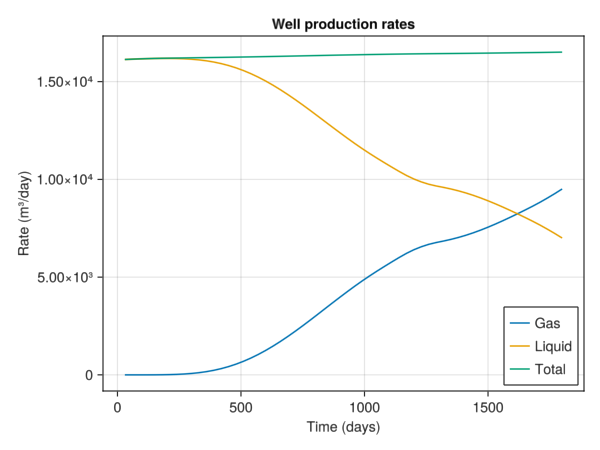

In [19]:
qg = wd[:Producer][:grat]
qt = wd[:Producer][:rate]
ql = qt - qg
x = t/day
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Time (days)",
                     ylabel = "Rate (m³/day)",
                     title = "Well production rates")
lines!(ax, x, abs.(qg).*day, label = "Gas")
lines!(ax, x, abs.(ql).*day, label = "Liquid")
lines!(ax, x, abs.(qt).*day, label = "Total")
axislegend(position = :rb)
fig

## Plot bottom hole pressure of the injector
The pressure builds during injection, until the gas breaks through to the
other well.

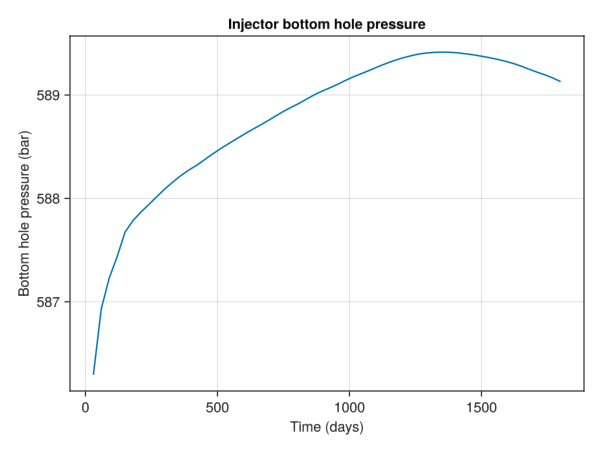

In [20]:
bh = wd[:Injector][:bhp]
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Time (days)",
                     ylabel = "Bottom hole pressure (bar)",
                     title = "Injector bottom hole pressure")
lines!(ax, x, bh./bar)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*